# Импорты

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from langdetect import detect
from tqdm import tqdm
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import learning_curve
import pickle
import warnings

# Описание импортов

```Python
import pandas as pd
```

- Библиотека для чтения и записи данных
___
```Python
import matplotlib.pyplot as plt
``` 
- Библиотека для визуализации данных
___
```Python
from collections import Counter
``` 
- Функция для подсчёта повторов слов в данных
___
```Python
import nltk
``` 
- Библиотека для обработки текста
___
```Python
from nltk.corpus import stopwords
``` 
- Список стоп-слов
___
```Python
from nltk.tokenize import word_tokenize
``` 
- Функция для токиницирования строки
___
```Python
from nltk.stem import SnowballStemmer
``` 
- Функция для обработки слов
___
```Python
from langdetect import detect
```
- Библиотека для определения основного языка текста
___
```Python
from tqdm import tqdm
```
- Библиотека для визуализации прогресс бара
___
```Python
import string
```
- Библиотека, содержащая всю пунктуацию
___
```Python
from sklearn.model_selection import train_test_split
```
- Библиотека для разделения на тренировочную и тестовую выборку
___
```Python
from sklearn.feature_extraction.text import TfidfVectorizer
```
- Функция для векторизации предложения
___
```Python
from sklearn.linear_model import LogisticRegression
```
- Модель
___
```Python
from sklearn.metrics import classification_report
```
- Метрика
___
```Python
from sklearn.metrics import plot_roc_curve
```
- Функция для построения графиков
___
```Python
from sklearn.metrics import plot_precision_recall_curve
```
- функция для построения графиков
___
```Python
from sklearn.model_selection import learning_curve
```
- Функция для построения кривой обучения
___
```Python
import pickle
```
- Библиотека для сохранения модели
___
```Python
import warnings
```
- Библиотека, отключающая предупреждения pandas


## Отключение предупреждений

In [2]:
warnings.filterwarnings("ignore")

# Первичная обработка 

In [3]:
data = pd.read_csv("labeledEN.csv")

Загрузка данных с токсичными сообщениями

In [4]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
data.dtypes

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object

In [6]:
data.toxic = data.toxic.apply(int)

In [22]:
data = data.rename(columns={"comment_text": "comment"})

In [10]:
data = data.drop(["id", "severe_toxic", "obscene", "threat", "insult", "identity_hate"], axis=1)

In [19]:
data.head()

,comment_text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [11]:
data.size

447098

In [12]:
data = data.drop_duplicates()

Удаления дубликатов для обучения

## Проверка на null значения

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 223549 entries, 0 to 223548
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_text  223549 non-null  object
 1   toxic         223549 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 5.1+ MB


## Визуализация отношения токсичных сообщений к обычным

Text(0.5, 1.0, 'Отношение сообщений')

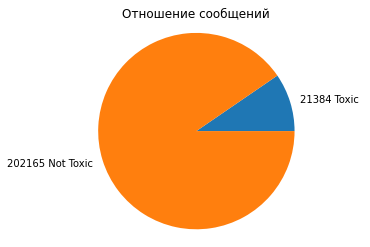

In [14]:
labels = [f"{len(data.loc[data.toxic == 1])}" + " Toxic", f"{len(data.loc[data.toxic == 0])}" + " Not Toxic"]
fig, ax = plt.subplots()
ax.pie([len(data.loc[data.toxic == 1]), len(data.loc[data.toxic == 0])], labels=labels)
ax.axis("equal")
plt.title("Отношение сообщений")

Круговая диаграмма отношения

Из данной диаграммы можно сделать вывод, что токсичных сообщений _меньше_, чем обычных, следовательно, точность определения токсичных сообщений может снизиться

# Финальная обработка данных

## Первичная обработка текста

In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anoni\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Загрузка stopwords

_Слова по типу "of", "were" и тд._

In [16]:
snowball = SnowballStemmer(language="english")
russian_stop_words = stopwords.words("english")

In [24]:
def tokinize_sentence(sentence: str):
    sentence = sentence.strip().lower()
    try:
        if detect(sentence) == "ru":
            sentence.replace("e", "е").replace("a", "а").replace("c", "с").replace("p", "р").replace("o", "о").replace("M", "м").replace("H", "н").replace("B", "в")
            sentence.replace("не ", "не").replace("no ", "no")
    except:
        pass
    sentence.replace("\t", " ")
    for i in string.punctuation:
        if i in sentence and i != " ":
            sentence = sentence.replace(i, '')
    tokens = word_tokenize(sentence, language="english")
    tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return " ".join(tokens)

### Описание функции
___
```Python
sentence = sentence.strip().lower()
```
- Удаление "\n" из текста, приведение к нижнему регистру
___
```Python
if detect(sentence) == "ru":
```
- Проверка на основной язык текста
___
```Python
sentence.replace("e", "е").replace("a", "а").replace("c", "с")...
```
- Замена английских букв на схожие русские _(Если основной язык русский)_
___
```Python
for i in string.punctuation:
        if i in sentence and i != " ":
            sentence = sentence.replace(i, '')
```
- Удаление пунктуации из текста
___
```Python
tokens = word_tokenize(sentence, language="english")
```
- Токенизация предложений
___
```Python
tokens = [i for i in tokens if i not in russian_stop_words]
```
- Удаление стоп слов из текста
___
```Python
tokens = [snowball.stem(i) for i in tokens]
```
- Удаление окончаний
___
```Python
return " ".join(tokens)
```
- Возврат преобразованного текста

In [25]:
tqdm.pandas()

data_token = data.copy()
data_token.comment = data_token.comment.progress_apply(tokinize_sentence)
data_token.head()

100%|█████████████████████████████████████████████████████████████████████████| 223549/223549 [14:21<00:00, 259.58it/s]


,comment,toxic
0,explan edit made usernam hardcor metallica fan...,0
1,daww match background colour im seem stuck tha...,0
2,hey man im realli tri edit war guy constant re...,0
3,cant make real suggest improv wonder section s...,0
4,sir hero chanc rememb page that,0


Обработка данных для дальнейшего обучения
___
_Убераем окончания, приводим слова в нижний регистр_

## Удаление дубликатов и пустых значений

### Поиск и удаление пустых значений

In [26]:
data = data_token.copy()
empty = data[data.comment == '']
print('Количество пустых значений: ', len(empty))
data = data.drop(empty.index)

Количество пустых значений:  54


### Поиск дубликатов

In [27]:
print('Дубликаты: ', data.duplicated().sum())

Дубликаты:  1798


### Удаление дубликатов

In [28]:
data = data.drop_duplicates()

Первичное удаление дубликатов

In [29]:
comment_duplicated = data[data.comment.duplicated('last')]
comment_duplicated.head()

,comment,toxic
807,retard,1
3972,serious mental ill addict contruct thing ever ...,0
4308,vandal,1
4468,face truth cant escap userarilang1234 didnt ed...,0
4701,controversi remark alleg call facebook user du...,0


Вывод дубликатов

In [30]:
data = data.drop_duplicates(subset='comment')

Удаление дубликатов по столбцу comment

# Визуализация самых популярных слов

### Текстовая визуализация

In [31]:
sorted_counter = Counter(' '.join(data.comment.values).split()).most_common()
sorted_counter[:5]

[('articl', 100022),
 ('page', 73278),
 ('edit', 52188),
 ('wikipedia', 49251),
 ('use', 47115)]

### График самых частоупотребляемых слов

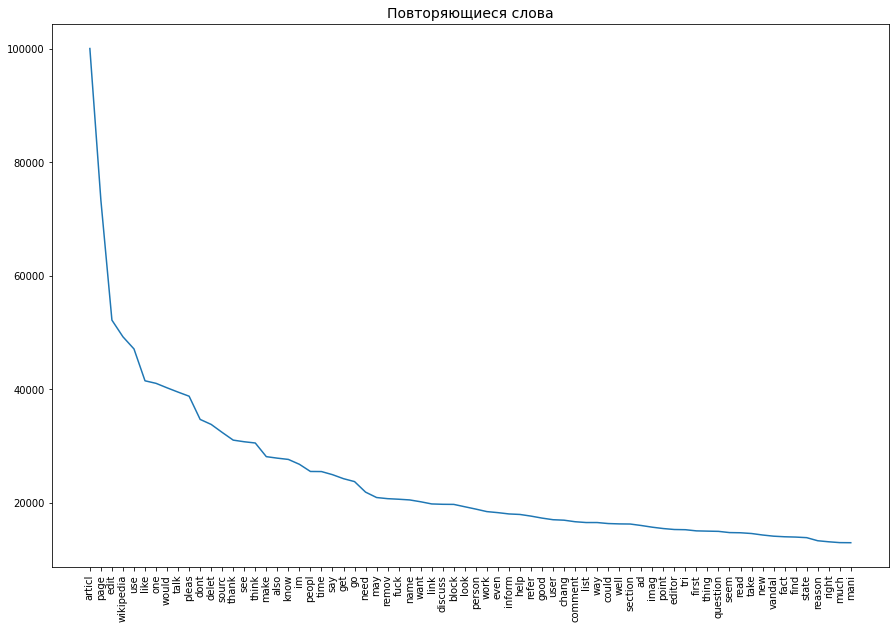

In [32]:
plt.figure(figsize=(15, 10))
plt.plot([i[0] for i in sorted_counter][:70], [i[1] for i in sorted_counter][:70])
plt.xticks(rotation=90)
plt.title('Повторяющиеся слова', fontsize=14)
plt.show()

### График длинны текста для токсичных сообщений

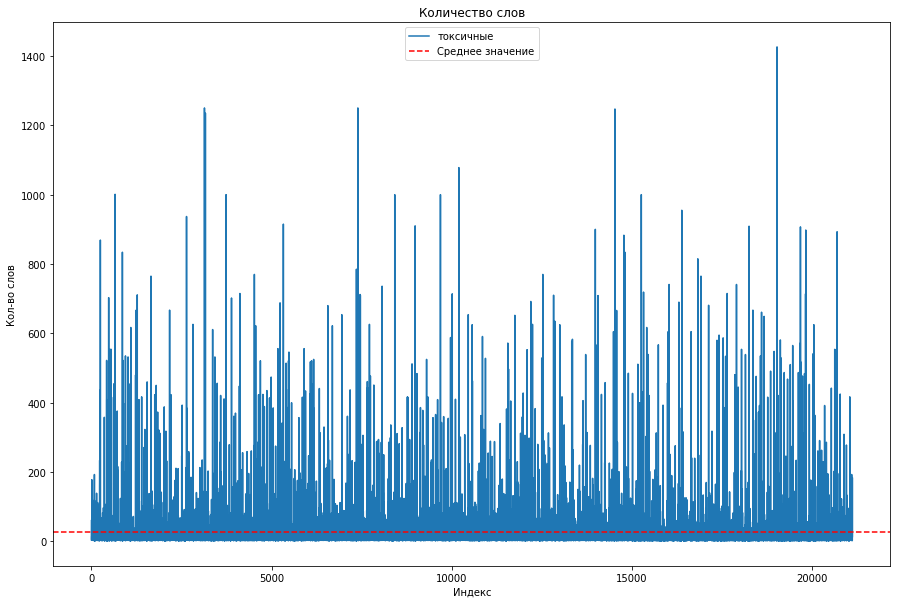

In [33]:
plt.figure(figsize=(15, 10))
plt.plot([len(i.split()) for i in data.loc[data.toxic == 1]["comment"]], label="токсичные")
plt.xlabel("Индекс")
plt.ylabel("Кол-во слов")
plt.title("Количество слов")
plt.axhline(pd.DataFrame([len(i.split()) for i in data.loc[data.toxic == 1]["comment"]]).mean()[0], linestyle="dashed", label="Среднее значение", c="r")
plt.legend(loc=9)
plt.show()

### График длинны текста для обычных сообщений

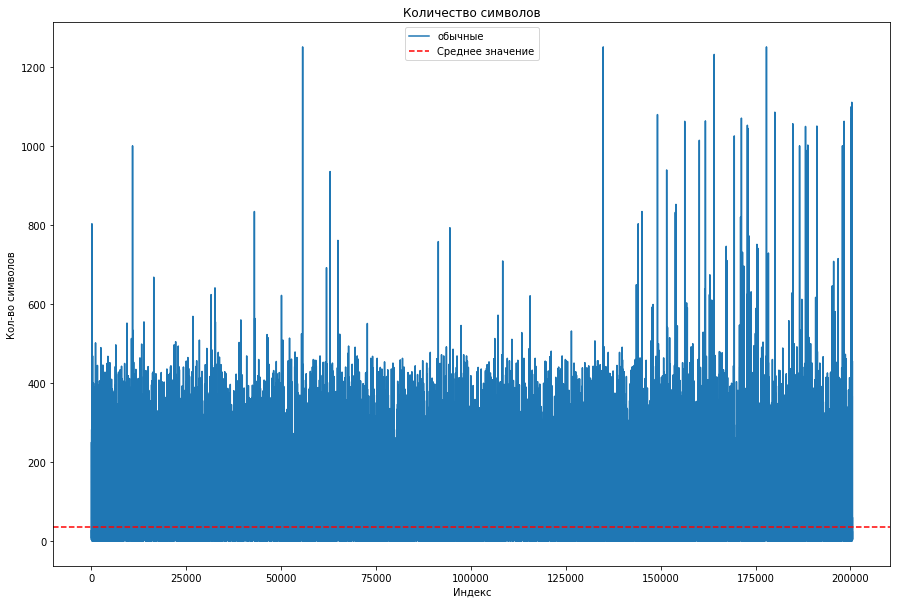

In [34]:
plt.figure(figsize=(15, 10))
plt.plot([len(i.split()) for i in data.loc[data.toxic == 0]["comment"]], label="обычные")
plt.xlabel("Индекс")
plt.ylabel("Кол-во символов")
plt.title("Количество символов")
plt.axhline(pd.DataFrame([len(i.split()) for i in data.loc[data.toxic == 0]["comment"]]).mean()[0], linestyle="dashed", label="Среднее значение", c="r")
plt.legend(loc=9)
plt.show()

### График длинны текста для токсичных сообщений наложенный на обычные

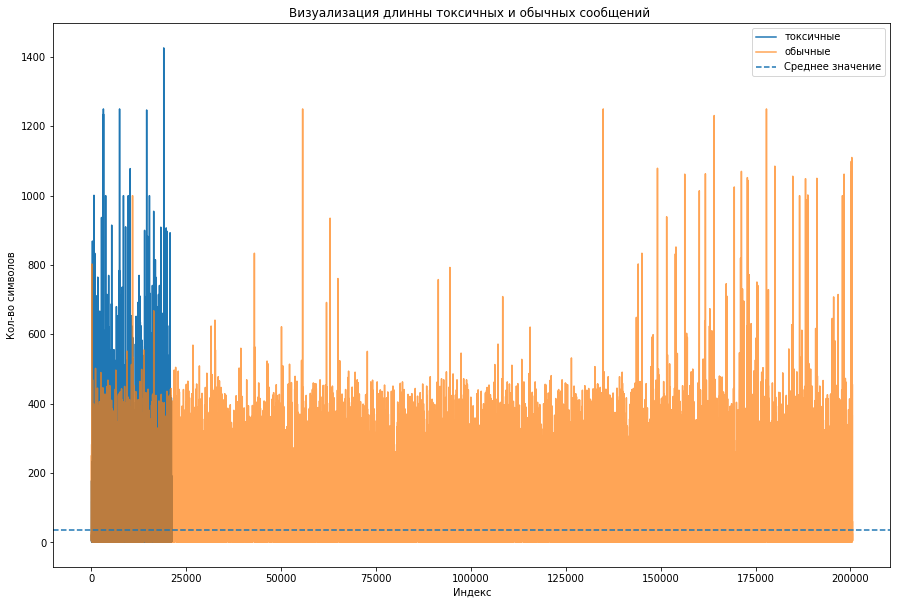

In [35]:
plt.figure(figsize=(15, 10))
plt.plot([len(i.split()) for i in data.loc[data.toxic == 1]["comment"]], label="токсичные")
plt.plot([len(i.split()) for i in data.loc[data.toxic == 0]["comment"]], alpha=0.7, label="обычные")
plt.xlabel("Индекс")
plt.ylabel("Кол-во символов")
plt.title("Визуализация длинны токсичных и обычных сообщений ")
plt.axhline(pd.DataFrame([len(i.split()) for i in data["comment"]]).mean()[0], linestyle="dashed", label="Среднее значение")
plt.legend(loc=1)
plt.show()

### Отношение количества обычных комментариев к токсичным

Text(0.5, 1.0, 'Отношение сообщений')

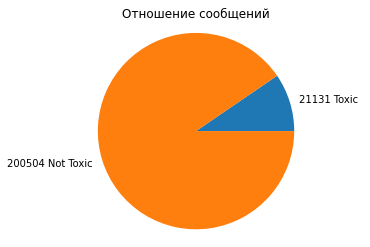

In [36]:
labels = [f"{len(data.loc[data.toxic == 1])}" + " Toxic", f"{len(data.loc[data.toxic == 0])}" + " Not Toxic"]
fig, ax = plt.subplots()
ax.pie([len(data.loc[data.toxic == 1]), len(data.loc[data.toxic == 0])], labels=labels)
ax.axis("equal")
plt.title("Отношение сообщений")

Исходя из данных предыдущей диаграммы можем сделать вывод, что при удалении дубликатов, были удалены **1661** обычных комментария и **253** токсичных

### Визуализация уменьшения длины сообщений

Text(0.5, 1.0, 'Визуализация начиная с самых длинных сообщений')

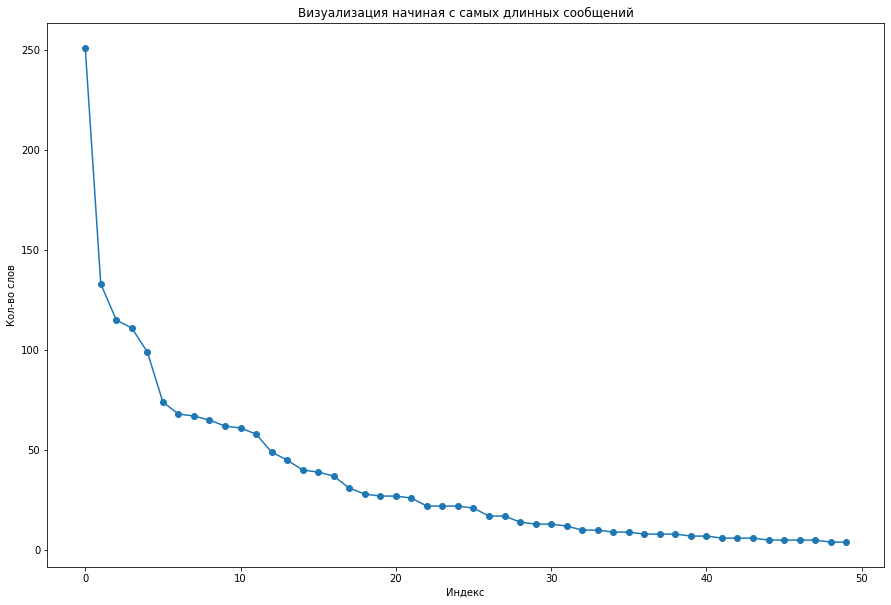

In [37]:
plt.figure(figsize=(15, 10))
plt.plot(sorted([len(i.split()) for i in data["comment"][:50]], reverse=True), marker="o")
plt.ylabel("Кол-во слов")
plt.xlabel("Индекс")
plt.title("Визуализация начиная с самых длинных сообщений")

### Визуализация увеличенния длины сообщений

Text(0.5, 1.0, 'Визуализация начиная с самых коротких сообщений')

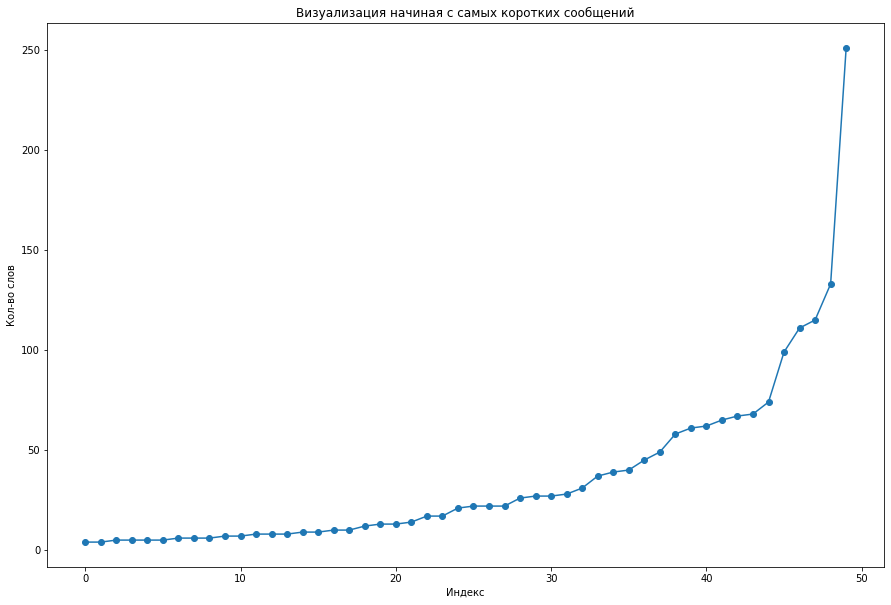

In [38]:
plt.figure(figsize=(15, 10))
plt.plot(sorted([len(i.split()) for i in data["comment"][:50]]), marker="o")
plt.ylabel("Кол-во слов")
plt.xlabel("Индекс")
plt.title("Визуализация начиная с самых коротких сообщений")

### Пересечение графика увеличения и уменьшения длины

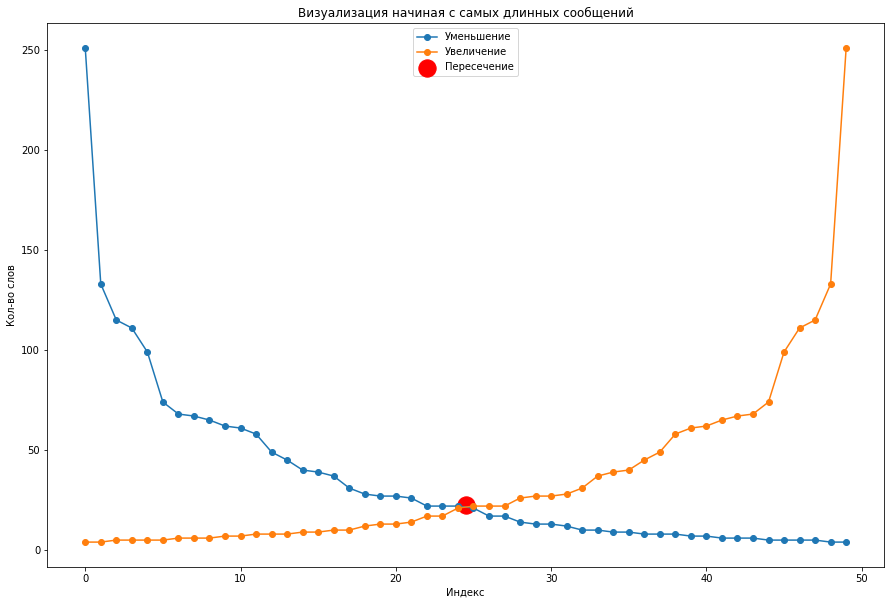

In [74]:
plt.figure(figsize=(15, 10))
plt.plot(sorted([len(i.split()) for i in data["comment"][:50]], reverse=True), marker="o", label="Уменьшение")
plt.plot(sorted([len(i.split()) for i in data["comment"][:50]]), marker="o", label="Увеличение")
plt.ylabel("Кол-во слов")
plt.xlabel("Индекс")
plt.title("Визуализация начиная с самых длинных сообщений")
plt.scatter(24.5, 22.6, c = 'red', s=300, label="Пересечение")
plt.legend(loc=9)

### Вывод средней длины сообщений

In [40]:
print("Среднее кол-во слов:", pd.DataFrame([len(i.split()) for i in data["comment"]]).mean()[0])
print("Среднее кол-во слов токсичных сообщений:", pd.DataFrame([len(i.split()) for i in data.loc[data.toxic == 1]["comment"]]).mean()[0])
print("Среднее кол-во слов обычных сообщений:", pd.DataFrame([len(i.split()) for i in data.loc[data.toxic == 0]["comment"]]).mean()[0])

Среднее кол-во слов: 35.034200374489586
Среднее кол-во слов токсичных сообщений: 27.378354076948558
Среднее кол-во слов обычных сообщений: 35.841045565175754


### Визуализация графиков длины сообщений (всех, токсичных и обычных) 

Text(0.5, 1.0, 'Визуализация начиная с самых длинных сообщений')

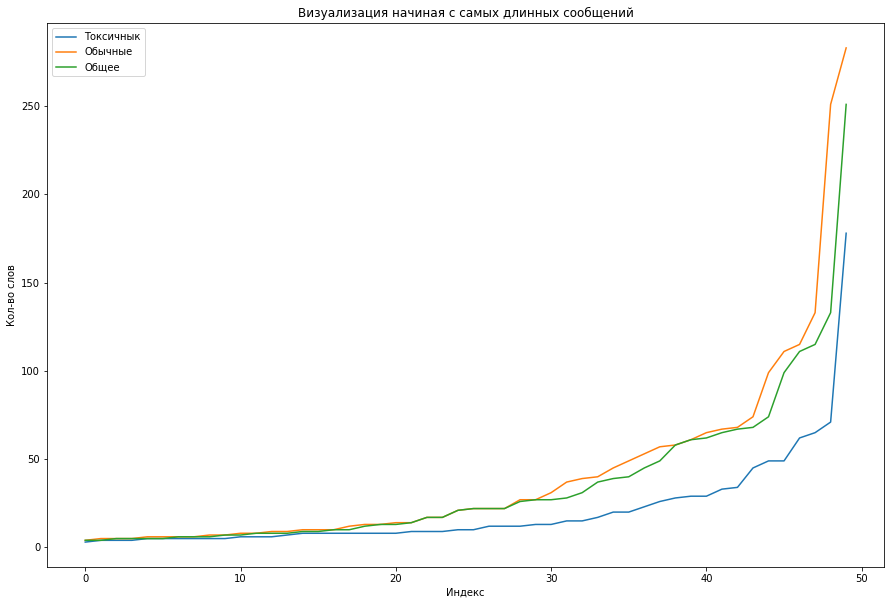

In [41]:
plt.figure(figsize=(15, 10))
plt.plot(sorted([len(i.split()) for i in data.loc[data.toxic == 1]["comment"]][:50]), label="Токсичнык")
plt.plot(sorted([len(i.split()) for i in data.loc[data.toxic == 0]["comment"]][:50]), label="Обычные")
plt.plot(sorted([len(i.split()) for i in data["comment"]][:50]), label="Общее")
plt.legend(loc=2)
plt.ylabel("Кол-во слов")
plt.xlabel("Индекс")
plt.title("Визуализация начиная с самых длинных сообщений")

### Визуализация графиков длины сообщений на более маленьком промежутке (всех, токсичных и обычных) 

Text(0.5, 1.0, 'Визуализация начиная с самых длинных сообщений')

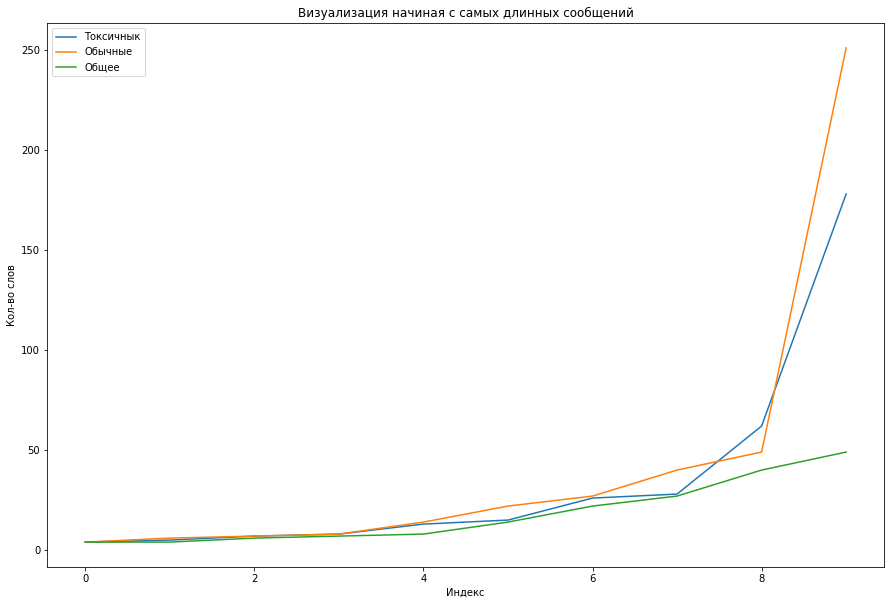

In [42]:
plt.figure(figsize=(15, 10))
plt.plot(sorted([len(i.split()) for i in data.loc[data.toxic == 1]["comment"]][:10]), label="Токсичнык")
plt.plot(sorted([len(i.split()) for i in data.loc[data.toxic == 0]["comment"]][:10]), label="Обычные")
plt.plot(sorted([len(i.split()) for i in data["comment"]][:10]), label="Общее")
plt.legend(loc=2)
plt.ylabel("Кол-во слов")
plt.xlabel("Индекс")
plt.title("Визуализация начиная с самых длинных сообщений")

# Разделение данных на тренировочную и тестовую выборки, создание фич

## Разделение на тренировочную и тестовую выборки

In [75]:
X_train, X_test, y_train, y_test = train_test_split(data["comment"], data["toxic"], test_size=0.20, random_state=3)

## Создание фичей

In [76]:
vectorizer = TfidfVectorizer(ngram_range=(2,4), analyzer='char_wb', max_df=0.8, min_df=10)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

print('Фичи: ', len(vectorizer.get_feature_names()))

Фичи:  68324


Создание фичей для обучения

# Обучение модели

## Создание и обучение модели

In [77]:
model = LogisticRegression(max_iter=10000, C=3, solver='liblinear')

Создание модели для обучения

In [78]:
model.fit(X_train, y_train)

LogisticRegression(C=3, max_iter=10000, solver='liblinear')

обучение модели

### Предсказание целевой переменной на тестовых данных

In [79]:
y_pred = model.predict(X_test)

Создание предсказаний

## Проверка score

### Вывод основных метрик

In [80]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     40014
           1       0.85      0.63      0.72      4313

    accuracy                           0.95     44327
   macro avg       0.90      0.81      0.85     44327
weighted avg       0.95      0.95      0.95     44327



Визуализация точности предсказаний

## Визуализация предсказаний

### Визуализация предсказаний тестовых данных


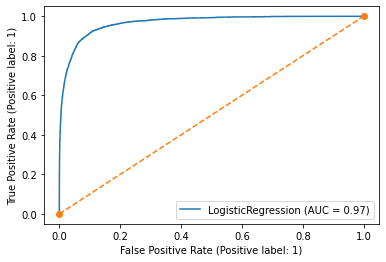

In [49]:
plot_roc_curve(model, X_test, y_test)
plt.plot([0, 1], [0, 1],'o--')
plt.show()

### Визуализация предсказаний тренировочных данных данных

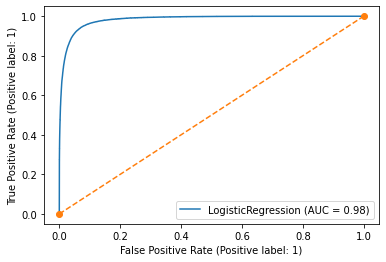

In [50]:
plot_roc_curve(model, X_train, y_train)
plt.plot([0, 1], [0, 1],'o--')
plt.show()

### Визуализация модели

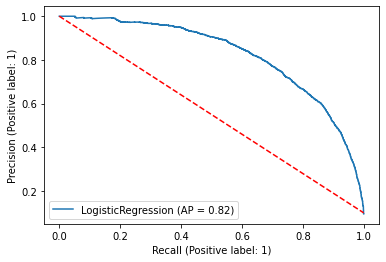

In [61]:
plot_precision_recall_curve(estimator=model, X=X_test, y=y_test)
plt.plot([0, 1], [1, 0.1],'r--')
plt.show()

In [52]:
train_sizes, train_scores, valid_scores = learning_curve(LogisticRegression(), X_train, y_train, train_sizes=[0.001, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9], cv=5)

plt.figure(figsize=(15, 10))
plt.plot(train_sizes, train_scores, valid_scores.mean(axis=1), lw=2,
         label='cross-validation')
plt.title('Кривая обучения')
plt.xlabel('x')
plt.ylabel('y')

Кривая обучения позволяет узнать оптимальное количество данных для обучения

# Тест и сохраниение модели

## Тестирование модели

In [59]:
toxic_propabality = model.predict_proba(vectorizer.transform([tokinize_sentence("i love u")]))[0, 1]
print(f'Probability of toxicity: {toxic_propabality:.3f}')

Probability of toxicity: 0.157


```Python
toxic_propabality = model.predict_proba(vectorizer.transform([tokinize_sentence("i love u")]))[0, 1]
```
Определение токсичности сообщения
```Python
Probability of toxicity: 0.157
```
Вероятность того, что сообщение токсичное

## Сохраниение модели

In [55]:
with open("model.bf", "+wb") as file:
    pickle.dump(model, file)

Сохранение модели